In [1]:
!pip install statsmodels --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller # This line should work after installing statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv(r'/content/merged_df.csv')

In [3]:
df.head()

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT,Year
0,71573099999,01-01-2015,42.866667,-80.55,232,"DELHI CS ONT, CA",22.0,24,11.6,24,...,28.0,28.2,*,17.8,*,0.00,G,999.9,0,2015
1,71573099999,02-01-2015,42.866667,-80.55,232,"DELHI CS ONT, CA",28.5,24,17.1,24,...,21.0,31.6,,17.4,,0.00,G,999.9,0,2015
2,71573099999,03-01-2015,42.866667,-80.55,232,"DELHI CS ONT, CA",25.4,24,22.2,22,...,999.9,32.4,*,19.0,*,0.05,G,999.9,0,2015
3,71573099999,04-01-2015,42.866667,-80.55,232,"DELHI CS ONT, CA",34.2,23,33.9,23,...,21.0,40.6,,20.8,,1.25,G,0.4,0,2015
4,71573099999,05-01-2015,42.866667,-80.55,232,"DELHI CS ONT, CA",14.7,24,7.9,24,...,24.9,40.6,,6.3,,0.05,G,999.9,0,2015


In [4]:
df.shape

(3597, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3597 entries, 0 to 3596
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STATION           3597 non-null   int64  
 1   DATE              3597 non-null   object 
 2   LATITUDE          3597 non-null   float64
 3   LONGITUDE         3597 non-null   float64
 4   ELEVATION         3597 non-null   int64  
 5   NAME              3597 non-null   object 
 6   TEMP              3597 non-null   float64
 7   TEMP_ATTRIBUTES   3597 non-null   int64  
 8   DEWP              3597 non-null   float64
 9   DEWP_ATTRIBUTES   3597 non-null   int64  
 10  SLP               3597 non-null   float64
 11  SLP_ATTRIBUTES    3597 non-null   int64  
 12  STP               3597 non-null   float64
 13  STP_ATTRIBUTES    3597 non-null   int64  
 14  VISIB             3597 non-null   float64
 15  VISIB_ATTRIBUTES  3597 non-null   int64  
 16  WDSP              3597 non-null   float64


In [6]:
df.isna().sum()

,0
STATION,0
DATE,0
LATITUDE,0
LONGITUDE,0
ELEVATION,0
NAME,0
TEMP,0
TEMP_ATTRIBUTES,0
DEWP,0
DEWP_ATTRIBUTES,0


In [7]:
df.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'TEMP',
       'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES',
       'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP',
       'WDSP_ATTRIBUTES', 'MXSPD', 'GUST', 'MAX', 'MAX_ATTRIBUTES', 'MIN',
       'MIN_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNDP', 'FRSHTT', 'Year'],
      dtype='object')

In [8]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')  # Specify the correct format

In [9]:
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Day'] = df['DATE'].dt.day
df['Month_Name'] = df['DATE'].dt.month_name()
df['Day_Name'] = df['DATE'].dt.day_name()

In [10]:
# prompt: uique year

# Assuming 'df' is your DataFrame and it has a 'Year' column
unique_years = df['Year'].unique()
unique_years


array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype=int32)

# **EDA**

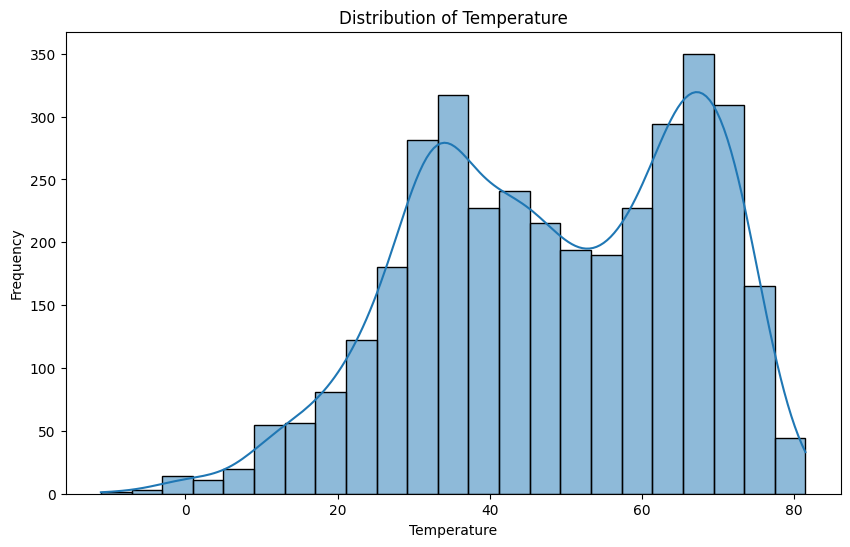

In [11]:
# prompt: plot the distribution of temp

# Plotting the distribution of 'temp'
plt.figure(figsize=(10, 6))
sns.histplot(df['TEMP'], kde=True)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


In [12]:
import plotly.express as px
fig = px.line(df, x='DATE', y=['TEMP', 'MAX', 'MIN'], title='Temperature Over Time')
fig.show()

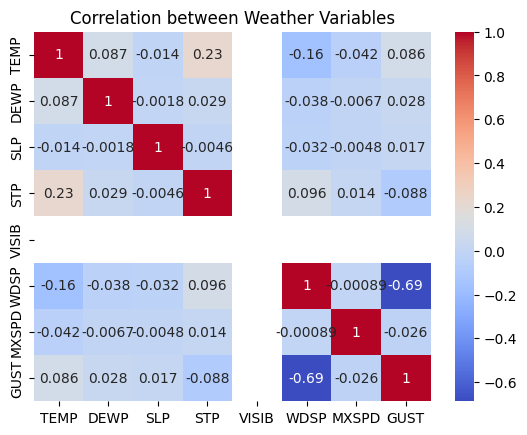

In [13]:
weather_vars = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST']
sns.heatmap(df[weather_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Weather Variables')
plt.show()

# **Single variate analysis**

In [14]:
data = df[['DATE', 'TEMP']]
data.head()

,DATE,TEMP
0,2015-01-01,22.0
1,2015-01-02,28.5
2,2015-01-03,25.4
3,2015-01-04,34.2
4,2015-01-05,14.7


In [15]:
# check for stationary and non-stationary using ADF test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(data['TEMP'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.497198
p-value                           0.008059
#Lags Used                       23.000000
Number of Observations Used    3573.000000
Critical Value (1%)              -3.432182
Critical Value (5%)              -2.862349
Critical Value (10%)             -2.567201
dtype: float64


data is stationary as p-value<0.05, Null hypothesis rejected.

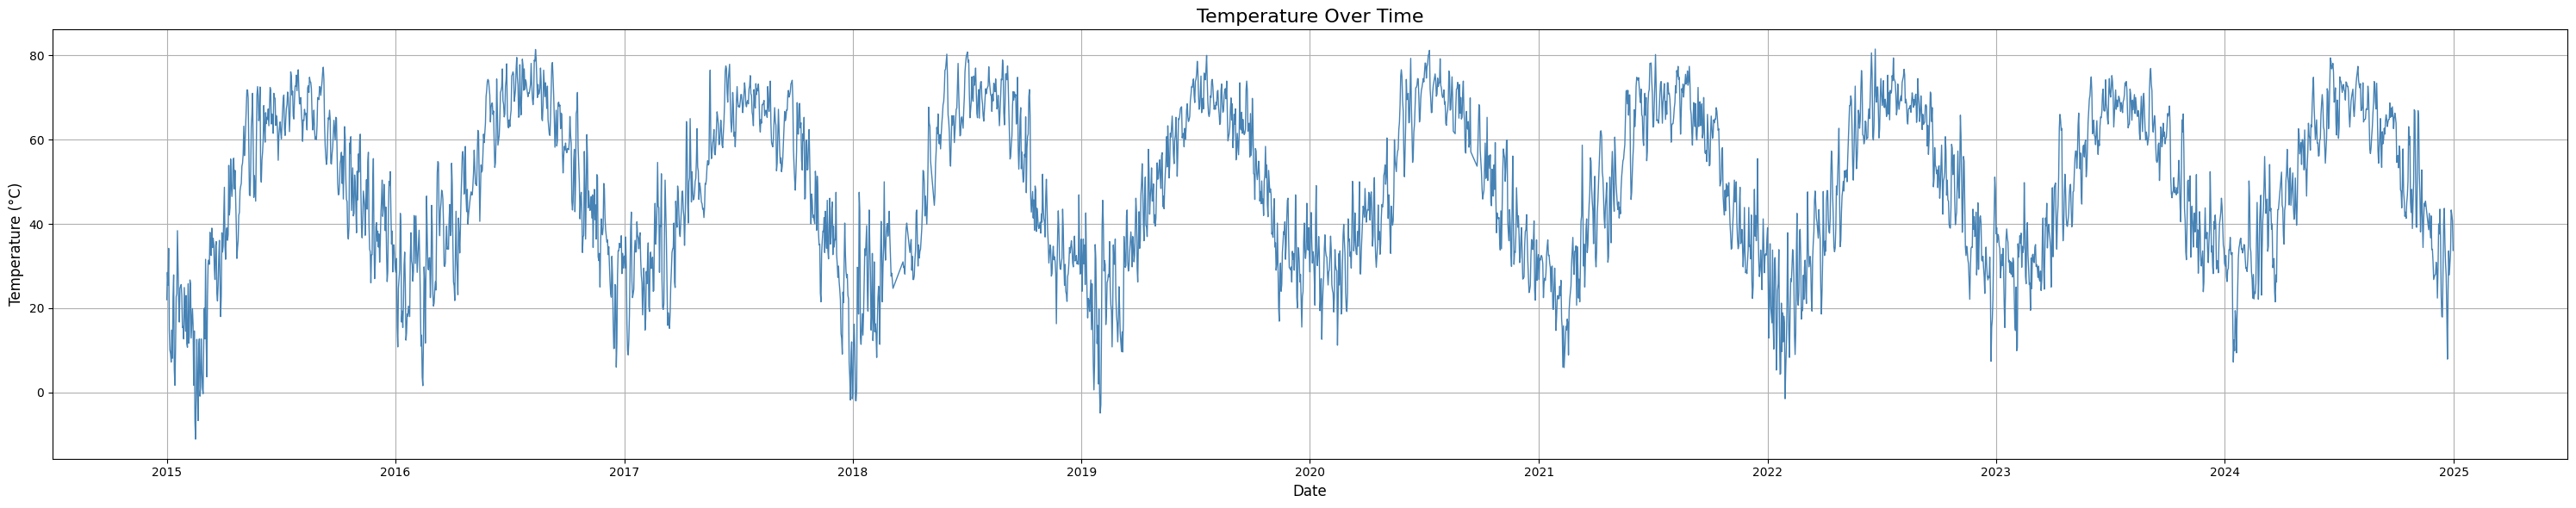

In [16]:
# Convert DATE to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')

# Sort by date to ensure correct plotting
df = df.sort_values('DATE')

# Plotting temperature over time
plt.figure(figsize=(30, 6))
plt.plot(df['DATE'], df['TEMP'], color='steelblue', linewidth=1)
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-17-5f4898ae2aad>:16: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



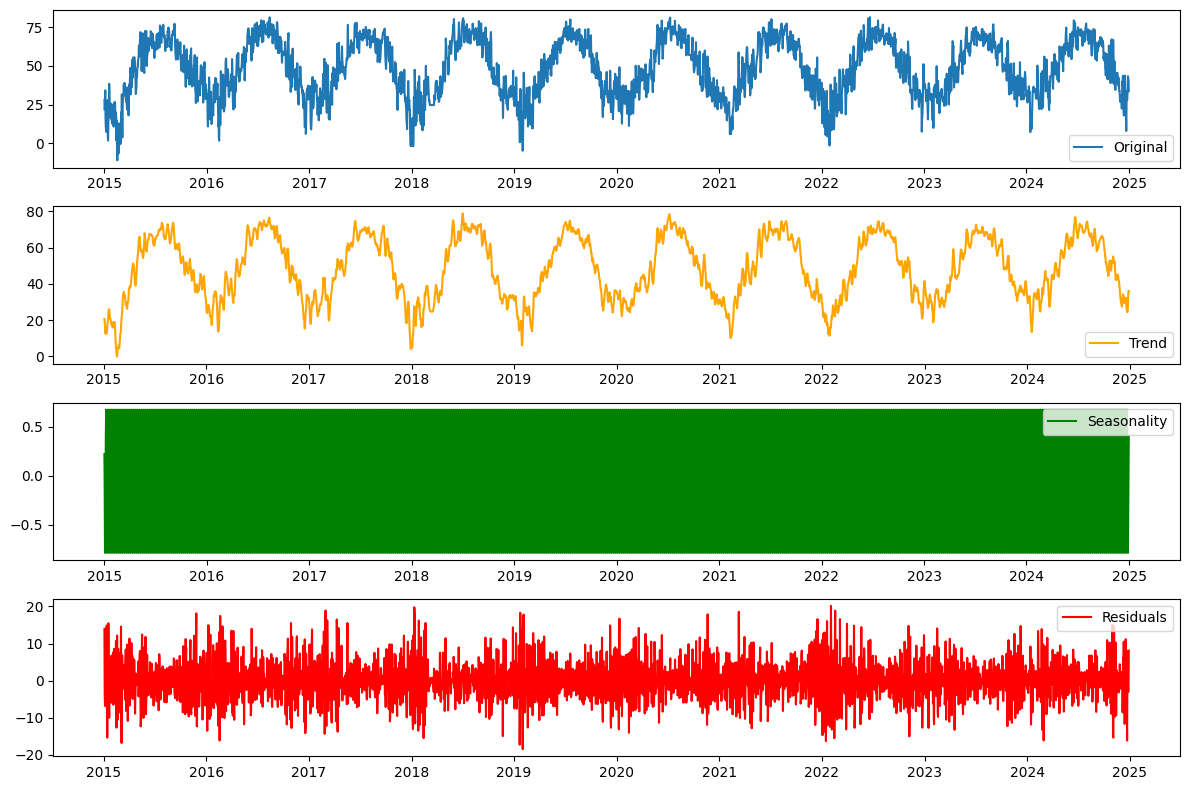

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume df is already loaded with 'DATE' and 'TEMP'

# 0. Define numeric columns properly
numeric_cols = ['TEMP']  # OR detect automatically:
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 1. Set 'DATE' as index
df_numeric = df.set_index('DATE')[numeric_cols]

# 2. Resample to daily frequency and forward-fill missing values
df_numeric = df_numeric.resample('D').mean().fillna(method='ffill')

# 3. Decompose TEMP column
decomposition = seasonal_decompose(df_numeric['TEMP'], model='additive')  # or 'multiplicative'

# 4. Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 5. Plot decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_numeric['TEMP'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# 6. Reindex components to match original df
trend = trend.reindex(df.index)
seasonal = seasonal.reindex(df.index)
residual = residual.reindex(df.index)

# 7. Add components back to df
df['Trend'] = trend.values
df['Seasonal'] = seasonal.values
df['Residual'] = residual.values

# (Optional) Reset index
# df = df.reset_index()



=== Naive Forecast on Test Set ===
MAE: 4.30
RMSE: 5.73
R² Score: 0.87


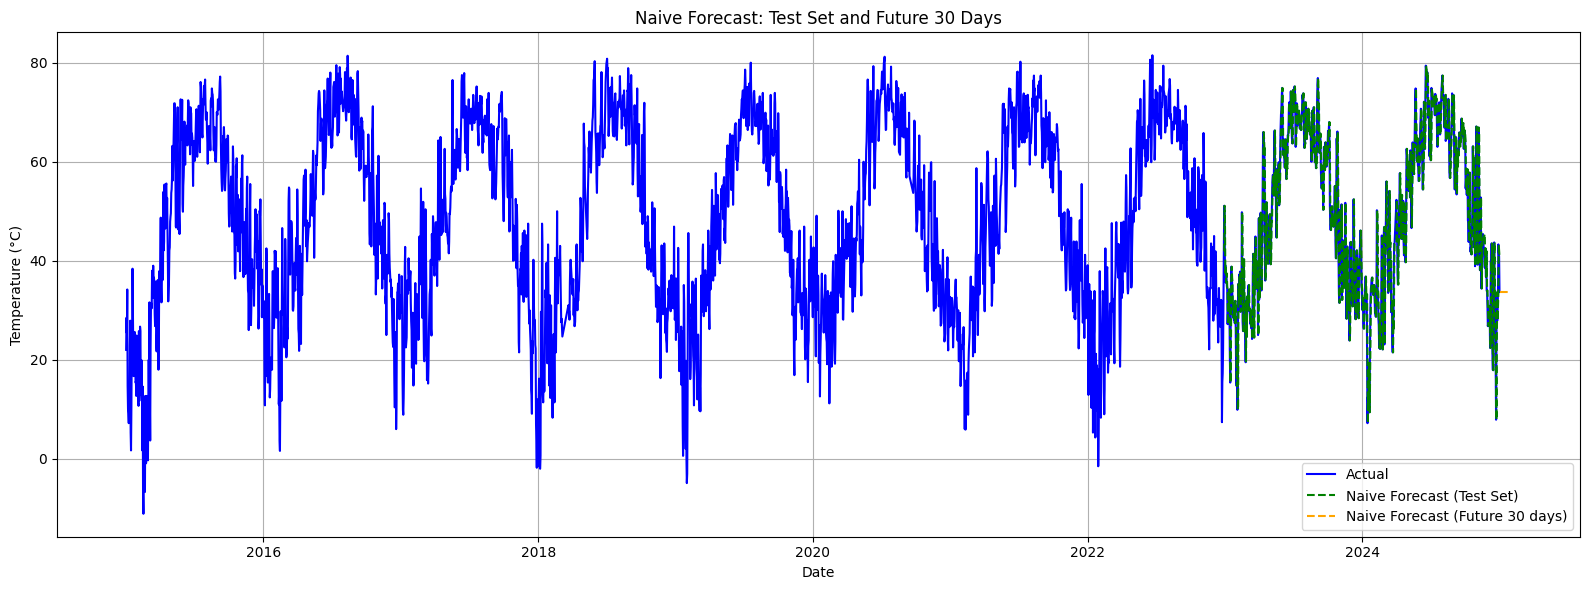


=== 30 Days Future Forecast (Numeric) ===
      Date  Forecasted_TEMP
2025-01-01             33.7
2025-01-02             33.7
2025-01-03             33.7
2025-01-04             33.7
2025-01-05             33.7
2025-01-06             33.7
2025-01-07             33.7
2025-01-08             33.7
2025-01-09             33.7
2025-01-10             33.7
2025-01-11             33.7
2025-01-12             33.7
2025-01-13             33.7
2025-01-14             33.7
2025-01-15             33.7
2025-01-16             33.7
2025-01-17             33.7
2025-01-18             33.7
2025-01-19             33.7
2025-01-20             33.7
2025-01-21             33.7
2025-01-22             33.7
2025-01-23             33.7
2025-01-24             33.7
2025-01-25             33.7
2025-01-26             33.7
2025-01-27             33.7
2025-01-28             33.7
2025-01-29             33.7
2025-01-30             33.7


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert DATE to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')

# Sort by date
df = df.sort_values('DATE')
ts = df.set_index('DATE')['TEMP']

# Train-test split (80% train, 20% test)
split_idx = int(len(ts) * 0.8)
train, test = ts[:split_idx], ts[split_idx:]

# ====== 1. Naive Forecast on Test Set ======
# Naive forecast: forecast[t] = actual[t-1]
naive_forecast = test.shift(1)
naive_forecast.iloc[0] = train.iloc[-1]  # First prediction uses last train value

# Evaluation
mae = mean_absolute_error(test, naive_forecast)
rmse = np.sqrt(mean_squared_error(test, naive_forecast))
r2 = r2_score(test, naive_forecast)

print("\n=== Naive Forecast on Test Set ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# ====== 2. 30 Days Future Forecast ======
# We'll use the last known value to forecast forward
last_known_value = ts.iloc[-1]

future_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_forecast = pd.Series(last_known_value, index=future_dates)

# ====== 3. Plot Actual, Test Forecast, and Future Forecast ======
plt.figure(figsize=(16, 6))
plt.plot(ts.index, ts, label='Actual', color='blue')
plt.plot(test.index, naive_forecast, label='Naive Forecast (Test Set)', color='green', linestyle='--')
plt.plot(future_forecast.index, future_forecast, label='Naive Forecast (Future 30 days)', color='orange', linestyle='--')

plt.title('Naive Forecast: Test Set and Future 30 Days')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== 4. Print Future 30 Days Forecast ======
print("\n=== 30 Days Future Forecast (Numeric) ===")
future_forecast_df = future_forecast.reset_index()
future_forecast_df.columns = ['Date', 'Forecasted_TEMP']
print(future_forecast_df.to_string(index=False))



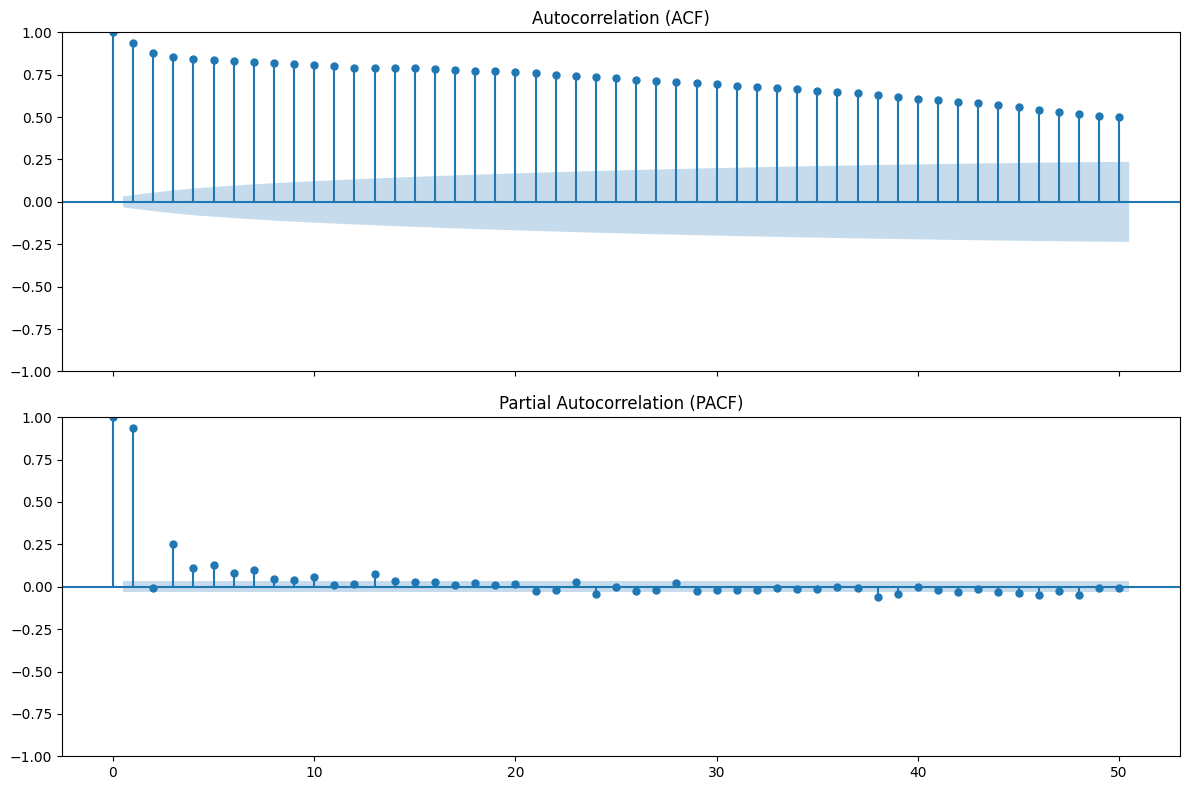

In [19]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

plot_acf(ts, ax=axes[0], lags=50)
axes[0].set_title('Autocorrelation (ACF)')

plot_pacf(ts, ax=axes[1], lags=50, method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

As we can see, for ACF plot there is slow decay and for PACF plot after 1st lag, there is sudden drop in spike, suggesting AR(1) model.

# **AR(1) Model**


=== Model Evaluation ===
AR(1) MAE: 14.1000
AR(1) MSE: 259.3058
R²: 0.0045


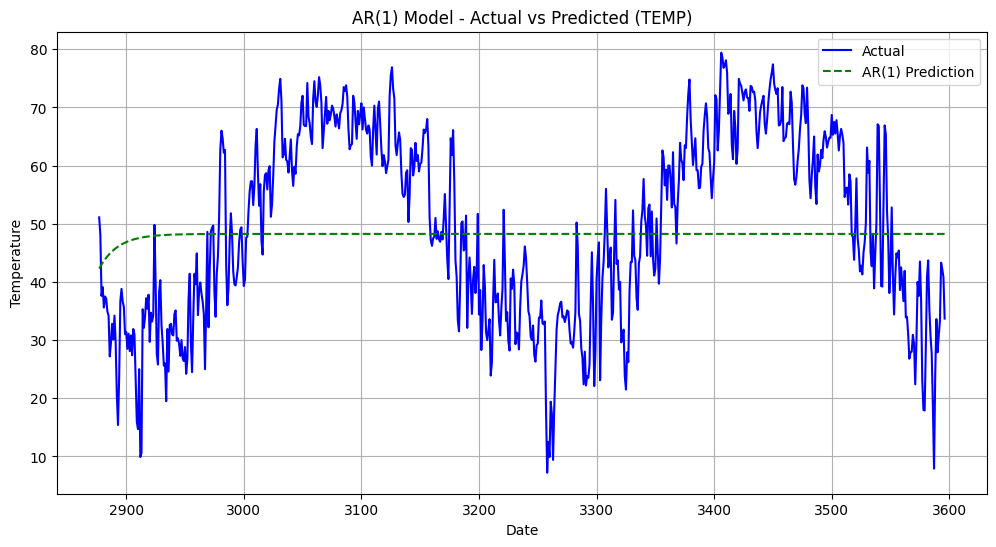

In [20]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 3. Drop NA if needed
temp_series = df['TEMP'].dropna()

# 4. Train-test split
split_index = int(0.8 * len(temp_series))
train, test = temp_series[:split_index], temp_series[split_index:]

# 5. Fit AR(1) model
model = AutoReg(train, lags=1).fit()

# 6. Forecast for test period
preds = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# 7. Evaluation
mae = mean_absolute_error(test, preds)
mse = mean_squared_error(test, preds)
r2 = r2_score(test, preds)

print("\n=== Model Evaluation ===")
print(f"AR(1) MAE: {mae:.4f}")
print(f"AR(1) MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# 8. Plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, preds, label='AR(1) Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('AR(1) Model - Actual vs Predicted (TEMP)')
plt.legend()
plt.grid(True)
plt.show()

# **ARMA model**

=== All AIC Values ===
                    AIC
(2, 0, 2)  18464.998839
(3, 0, 3)  18466.010844
(3, 0, 4)  18466.086015
(1, 0, 4)  18466.543390
(3, 0, 2)  18467.032407
(2, 0, 3)  18467.091876
(2, 0, 4)  18468.571182
(4, 0, 2)  18468.828685
(4, 0, 4)  18469.291060
(4, 0, 3)  18470.340892
(1, 0, 3)  18470.556021
(4, 0, 1)  18470.846053
(3, 0, 1)  18481.624813
(1, 0, 2)  18513.887917
(4, 0, 0)  18597.440103
(3, 0, 0)  18631.805808
(2, 0, 1)  18801.553372
(1, 0, 0)  18842.444597
(1, 0, 1)  18844.410820
(2, 0, 0)  18844.430407
(0, 0, 4)  19870.054294
(0, 0, 3)  20209.798046
(0, 0, 2)  20863.457570
(0, 0, 1)  22123.488059
(0, 0, 0)  25001.817595

=== Optimal Parameters ===
Best (p, d, q): (2, 0, 2) | AIC: 18465.00

=== Model Evaluation ===
MAE: 14.4131
MSE: 297.9105
R²: -0.1437


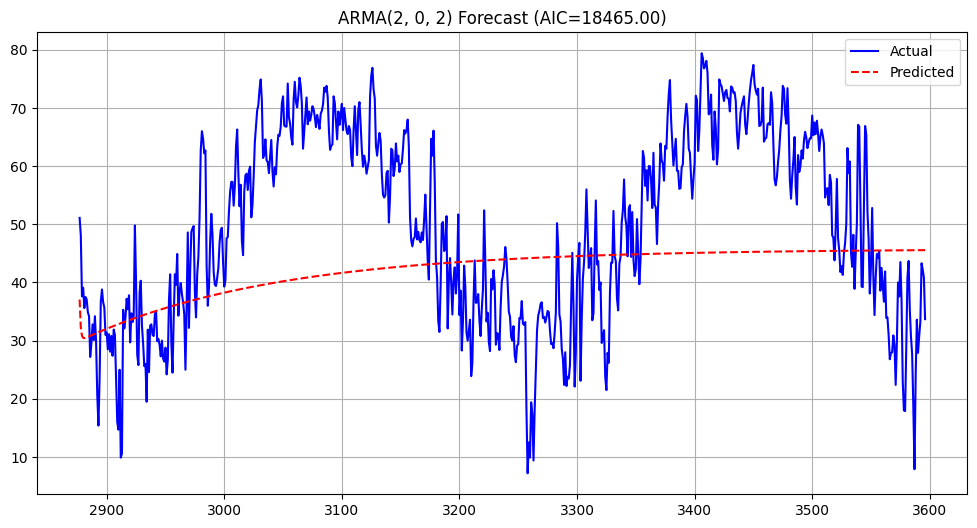

In [21]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

# Define p, d, q ranges (ARMA since d=0)
p = range(0, 5)  # AR order
q = range(0, 5)  # MA order
d = [0]          # No differencing

# Generate all (p, d, q) combinations
pdq = list(itertools.product(p, d, q))

# Store AIC results
results_aic = {}

# Fit all ARMA(p,q) models
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        results_aic[param] = results.aic
    except Exception as e:
        print(f"Failed for {param}: {str(e)}")
        continue

# Convert AIC results to a DataFrame for better visualization
aic_table = pd.DataFrame.from_dict(results_aic, orient='index', columns=['AIC'])
aic_table.sort_values(by='AIC', inplace=True)

# Highlight the minimum AIC
optimal_params = aic_table.idxmin()[0]
optimal_aic = aic_table.min()[0]

print("=== All AIC Values ===")
print(aic_table)
print("\n=== Optimal Parameters ===")
print(f"Best (p, d, q): {optimal_params} | AIC: {optimal_aic:.2f}")

# Fit the optimal model
optimal_model = ARIMA(train, order=optimal_params)
optimal_results = optimal_model.fit()

# Predictions
predictions = optimal_results.predict(start=len(train), end=len(train) + len(test) - 1)

# Evaluation
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)

print("\n=== Model Evaluation ===")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title(f"ARMA{optimal_params} Forecast (AIC={optimal_aic:.2f})")
plt.legend()
plt.grid()
plt.show()

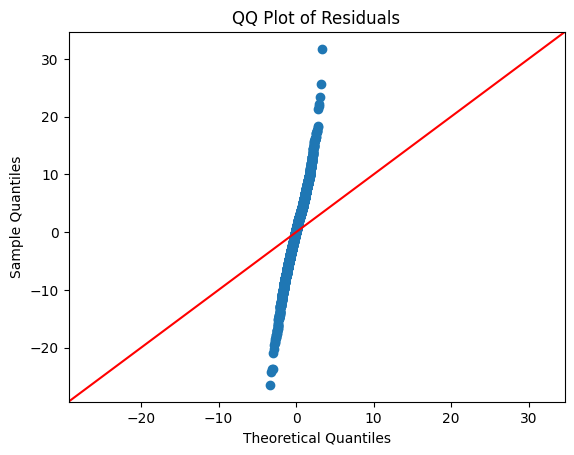

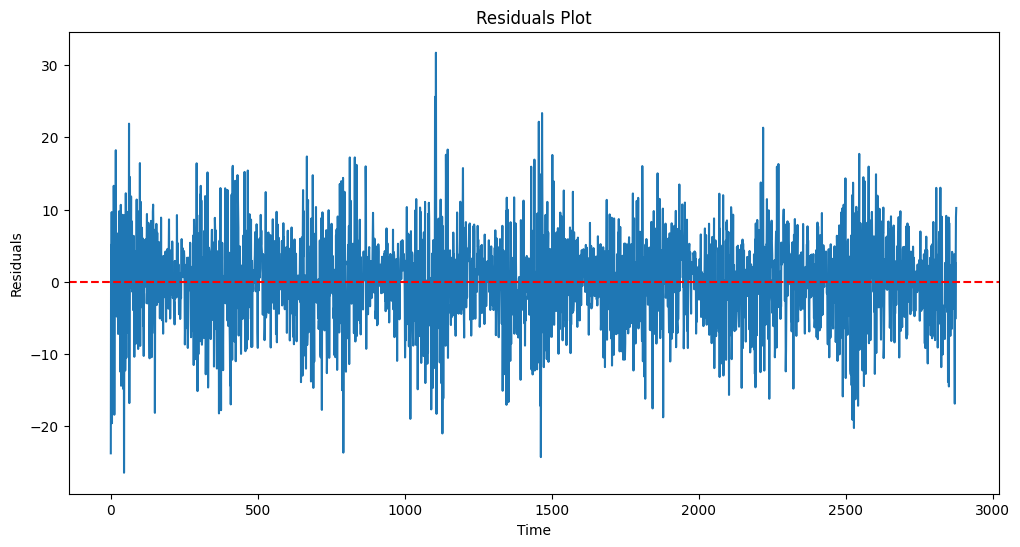


=== Ljung-Box Test ===
     lb_stat  lb_pvalue
1   0.006001   0.938252
2   0.018250   0.990916
3   0.143640   0.986129
4   0.163790   0.996824
5   0.341995   0.996778
6   1.172966   0.978199
7   1.728957   0.973310
8   1.786536   0.986871
9   2.899164   0.968159
10  2.900586   0.983668


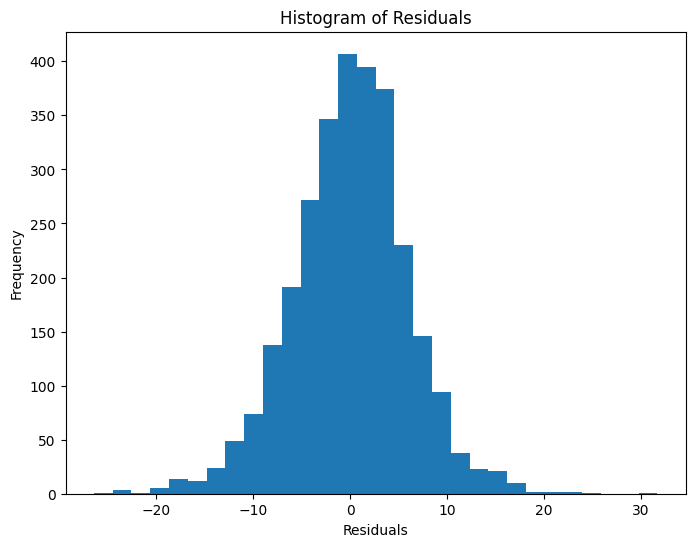

In [35]:
# prompt: make qq plot ,residuals plot,l junc box test,histogram, for above ARMA model

import statsmodels.api as sm
from scipy import stats

# Assuming 'optimal_results' is your fitted ARMA model
residuals = optimal_results.resid

# 1. QQ Plot
fig = sm.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

# 2. Residuals Plot
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 3. Ljung-Box Test
lb_test = sm.stats.acorr_ljungbox(residuals, lags=10) # Adjust the number of lags as needed
print("\n=== Ljung-Box Test ===")
print(lb_test)

# 4. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30)  # Adjust number of bins if needed
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# **SARIMA model**

In [22]:
# import itertools
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # === 1. Prepare Data ===
# # Ensure DATE is datetime and set as index
# df['DATE'] = pd.to_datetime(df['DATE'])
# df = df.set_index('DATE')

# temp_series = df['TEMP'].dropna()

# # Train-test split
# split_index = int(0.8 * len(temp_series))
# train, test = temp_series[:split_index], temp_series[split_index:]

# # === 2. Define Parameter Grid ===
# p = range(0, 3)
# d = range(0, 2)  # Allow d=0 or 1
# q = range(0, 3)

# P = range(0, 2)
# D = range(0, 2)  # Allow D=0 or 1
# Q = range(0, 2)

# s = 365  # Assuming yearly seasonality for daily temperature

# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# # === 3. Search Best SARIMA Model ===
# best_aic = float('inf')
# best_order = None
# best_seasonal_order = None
# best_model = None

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         try:
#             model = SARIMAX(train,
#                             order=param,
#                             seasonal_order=seasonal_param,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#             results = model.fit(disp=False)

#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = param
#                 best_seasonal_order = seasonal_param
#                 best_model = results
#         except:
#             continue

# # === 4. Evaluate Best Model ===
# # Predict on test set
# predictions = best_model.predict(start=len(train), end=len(train) + len(test) - 1)

# # Evaluation metrics
# mae = mean_absolute_error(test, predictions)
# mse = mean_squared_error(test, predictions)
# r2 = r2_score(test, predictions)

# print("\n=== Model Evaluation ===")
# print(f"Best SARIMA order: {best_order}")
# print(f"Best Seasonal order: {best_seasonal_order}")
# print(f"Best AIC: {best_aic:.4f}")
# print(f"Test MAE: {mae:.4f}")
# print(f"Test MSE: {mse:.4f}")
# print(f"Test R² Score: {r2:.4f}")

# # === 5. Plot Actual vs Predicted ===
# plt.figure(figsize=(12, 6))
# plt.plot(test.index, test, label='Actual', color='blue')
# plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='--')
# plt.title(f"SARIMA {best_order}x{best_seasonal_order} Forecast (AIC={best_aic:.2f})")
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

# # === 6. Forecast into the Future ===
# future_steps = 30  # Number of future days you want to forecast

# forecast_object = best_model.get_forecast(steps=future_steps)
# forecast_mean = forecast_object.predicted_mean
# forecast_ci = forecast_object.conf_int()

# # Future dates
# last_date = temp_series.index[-1]
# future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps)

# # === 7. Plot Future Forecast ===
# plt.figure(figsize=(14, 6))
# plt.plot(temp_series.index, temp_series, label='Observed', color='blue')
# plt.plot(future_dates, forecast_mean, label='Forecast', color='red')
# plt.fill_between(future_dates,
#                  forecast_ci.iloc[:, 0],
#                  forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
# plt.title(f"SARIMA {best_order}x{best_seasonal_order} Future {future_steps}-Day Forecast")
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

# # === 8. Future Forecast Table ===
# forecast_df = pd.DataFrame({
#     'Forecast': forecast_mean,
#     'Lower CI': forecast_ci.iloc[:, 0],
#     'Upper CI': forecast_ci.iloc[:, 1]
# }, index=future_dates)

# print("\n=== 30 Days Future Forecast ===")
# print(forecast_df.round(2))


# **RNN model**

In [24]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


Reloading Tuner from rnn_tuner_dir/rnn_forecast_tuning/tuner0.json

=== Best Hyperparameters Found ===
1st RNN Units: 128
2nd RNN Units: 96
3rd RNN Units: 80
Activation Function: relu
Optimizer: rmsprop
Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0262 - val_loss: 0.0147
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0070 - val_loss: 0.0162
Epoch 3/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0064 - val_loss: 0.0236
Epoch 4/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 5/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 6/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 7/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 8/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 9/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0053 - val_loss: 0.00

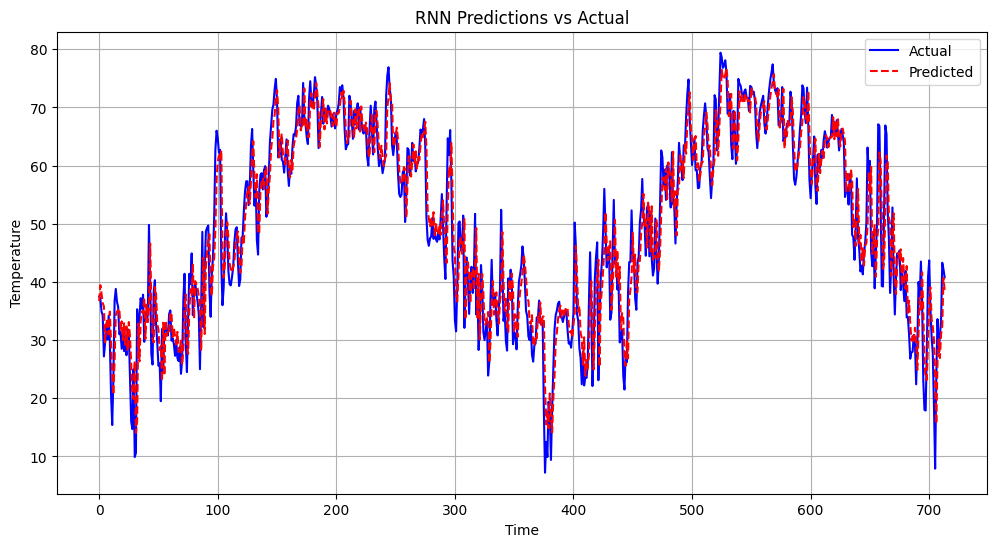

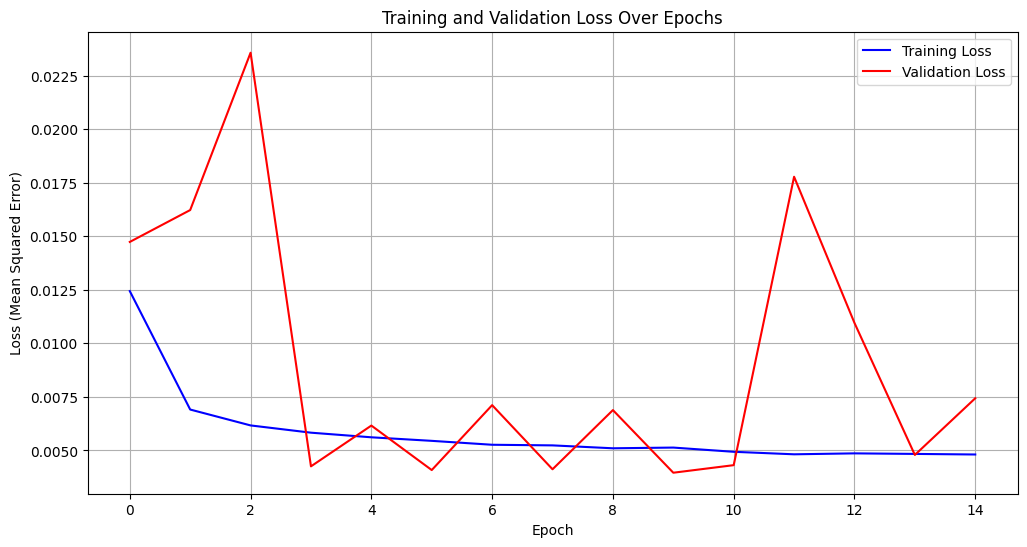


=== 30 Days Future Forecast (Numeric) ===
      Date  Forecasted_TEMP
2025-01-01        34.225063
2025-01-02        36.481434
2025-01-03        37.479431
2025-01-04        38.121384
2025-01-05        38.417736
2025-01-06        38.811260
2025-01-07        39.254047
2025-01-08        39.706215
2025-01-09        40.159348
2025-01-10        40.614254
2025-01-11        41.070385
2025-01-12        41.528454
2025-01-13        41.988251
2025-01-14        42.449959
2025-01-15        42.913483
2025-01-16        43.378918
2025-01-17        43.846268
2025-01-18        44.315525
2025-01-19        44.786694
2025-01-20        45.259781
2025-01-21        45.734802
2025-01-22        46.211758
2025-01-23        46.690651
2025-01-24        47.171494
2025-01-25        47.654297
2025-01-26        48.139072
2025-01-27        48.624893
2025-01-28        49.116566
2025-01-29        49.616447
2025-01-30        50.124523


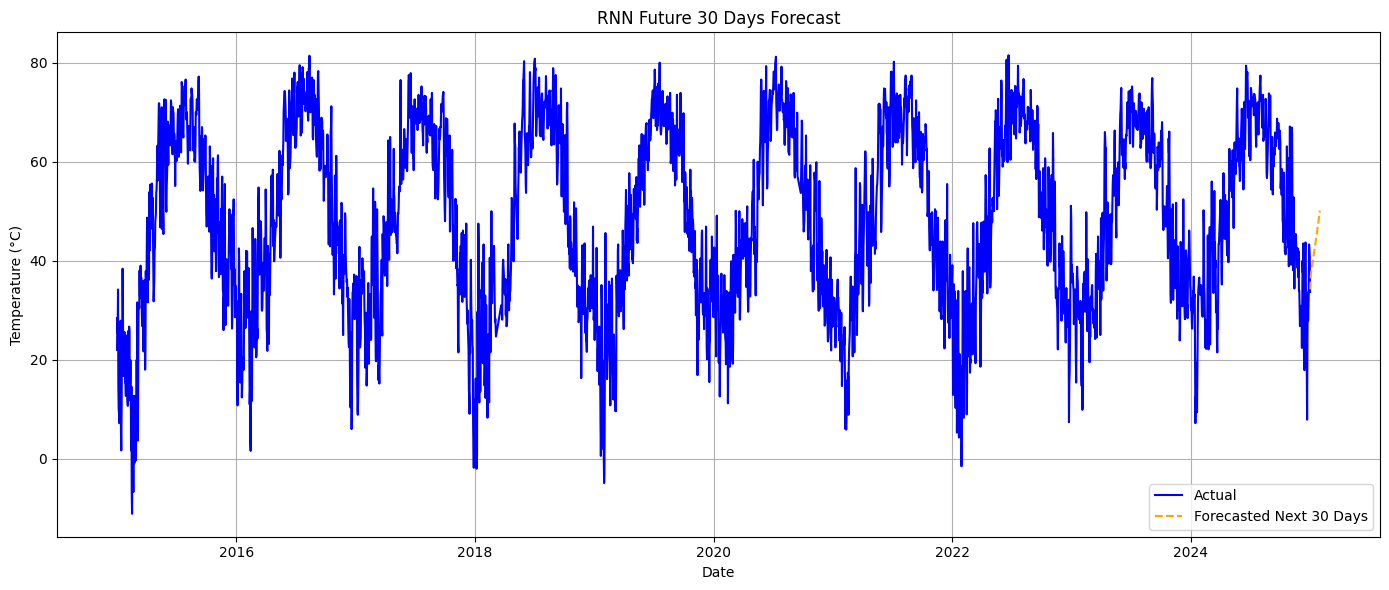

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Data Preparation ===
temp_series = df['TEMP'].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(np.array(temp_series).reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, Y = create_dataset(temp_scaled, look_back)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

# Reshape input for RNN [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# === 2. Hyperparameter Tuning ===
def build_model(hp):
    model = Sequential()
    # 1st RNN layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units1', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    # 2nd RNN layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units2', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=True
    ))
    # 3rd RNN layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units3', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh'])
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='rnn_tuner_dir',
    project_name='rnn_forecast_tuning'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run hyperparameter tuning
tuner.search(X_train, Y_train, epochs=50, batch_size=5, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n=== Best Hyperparameters Found ===")
print(f"1st RNN Units: {best_hp.get('rnn_units1')}")
print(f"2nd RNN Units: {best_hp.get('rnn_units2')}")
print(f"3rd RNN Units: {best_hp.get('rnn_units3')}")
print(f"Activation Function: {best_hp.get('activation')}")
print(f"Optimizer: {best_hp.get('optimizer')}")

# Build and train best model
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train, Y_train, epochs=100, batch_size=5, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# === 3. Make Predictions ===
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

# === 4. Evaluation ===
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))
train_r2 = r2_score(Y_train_inv[0], train_predict[:,0])  # Added Train R²
test_r2 = r2_score(Y_test_inv[0], test_predict[:,0])

print("\n=== Model Evaluation ===")
print('Train RMSE: %.2f' % (train_rmse))
print('Test RMSE: %.2f' % (test_rmse))
print('Train R² Score: %.2f' % (train_r2))  # Added Train R²
print('Test R² Score: %.2f' % (test_r2))

# === 5. Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(Y_test_inv[0], label='Actual', color='blue')
plt.plot(test_predict[:,0], label='Predicted', color='red', linestyle='--')
plt.title('RNN Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# === 6. Plot Training and Validation Loss ===
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

# === 7. Forecast 30 Future Days ===
future_input = temp_scaled[-look_back:]
future_input = future_input.reshape(1, look_back, 1)

future_predictions = []

for _ in range(30):
    future_pred = model.predict(future_input, verbose=0)
    future_predictions.append(future_pred[0, 0])
    future_input = np.append(future_input[:,1:,:], [[[future_pred[0,0]]]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create forecast DataFrame
future_forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_TEMP': future_predictions.flatten()})

# === 8. Display Future Predictions ===
print("\n=== 30 Days Future Forecast (Numeric) ===")
print(future_forecast_df.to_string(index=False))

# === 9. Plot Future Forecast ===
plt.figure(figsize=(14,6))
plt.plot(df['DATE'], df['TEMP'], label='Actual', color='blue')
plt.plot(future_forecast_df['Date'], future_forecast_df['Forecasted_TEMP'], label='Forecasted Next 30 Days', color='orange', linestyle='--')
plt.title('RNN Future 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Lstm model**

In [ ]:
!pip install tensorflow --quiet

Reloading Tuner from tuner_dir/lstm_forecast_tuning/tuner0.json

=== Best Hyperparameters Found ===
LSTM Units: 80
LSTM Activation: tanh
Dense Units: 112
Dense Activation: relu
Optimizer: adam
Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0710 - val_loss: 0.0059
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 10/100
14

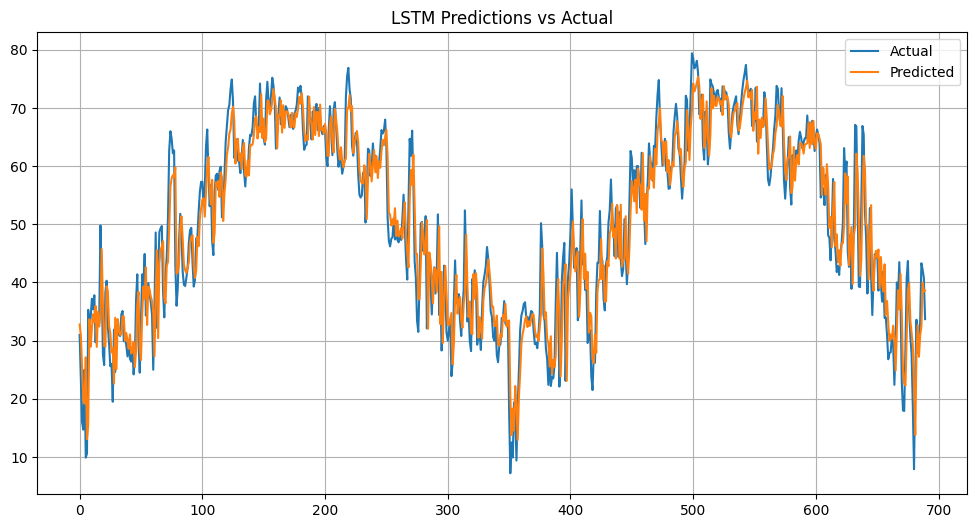

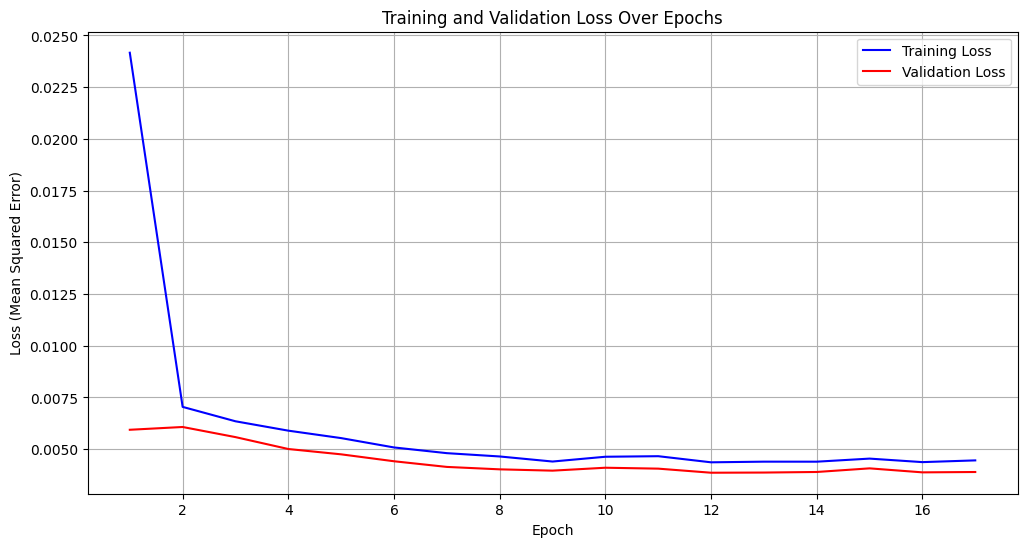


=== 30 Days Future Forecast ===
      Date  Forecasted_TEMP
2025-01-01        32.915394
2025-01-02        33.825588
2025-01-03        34.317425
2025-01-04        34.641247
2025-01-05        34.890873
2025-01-06        35.100307
2025-01-07        35.284046
2025-01-08        35.449833
2025-01-09        35.602005
2025-01-10        35.744022
2025-01-11        35.878044
2025-01-12        36.005238
2025-01-13        36.126957
2025-01-14        36.244549
2025-01-15        36.359528
2025-01-16        36.473053
2025-01-17        36.585430
2025-01-18        36.696205
2025-01-19        36.805130
2025-01-20        36.912209
2025-01-21        37.017197
2025-01-22        37.119747
2025-01-23        37.221001
2025-01-24        37.321690
2025-01-25        37.421398
2025-01-26        37.520096
2025-01-27        37.617893
2025-01-28        37.715214
2025-01-29        37.811855
2025-01-30        37.907551


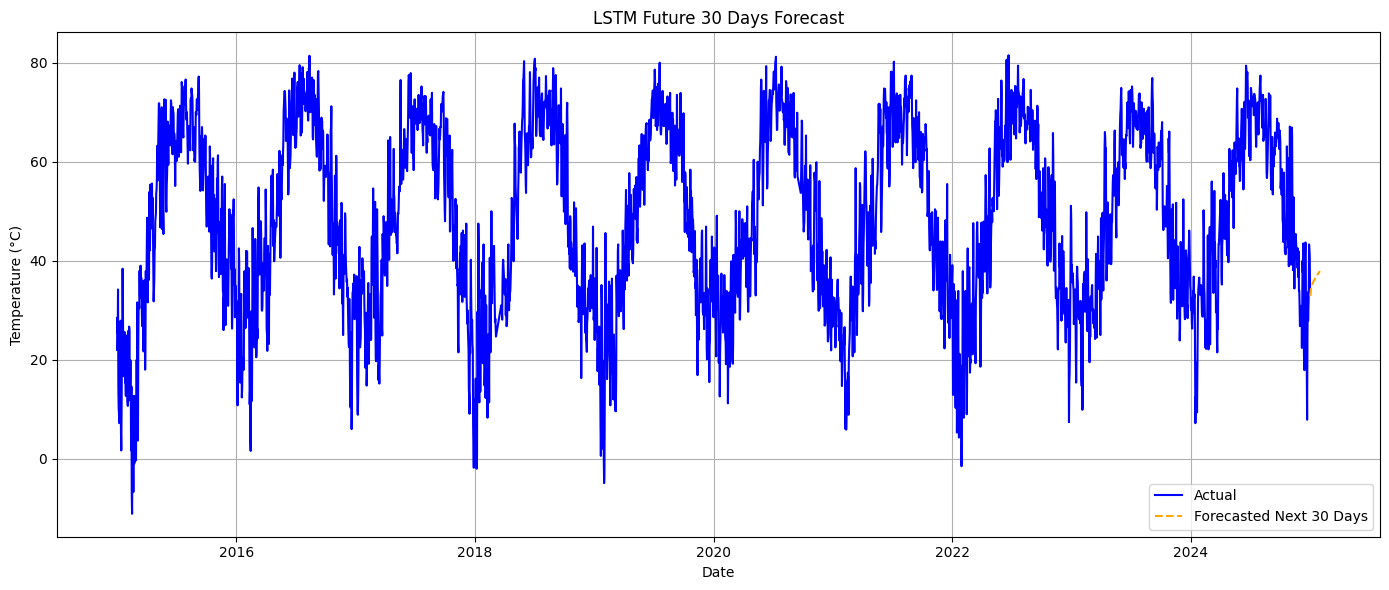

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# === 1. Data Preparation ===
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['TEMP']])

# Split
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# === 2. Hyperparameter Tuning ===
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_activation', ['relu', 'tanh'])
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mse'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='lstm_forecast_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start hyperparameter search
tuner.search(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n=== Best Hyperparameters Found ===")
print(f"LSTM Units: {best_hp.get('units')}")
print(f"LSTM Activation: {best_hp.get('activation')}")
print(f"Dense Units: {best_hp.get('dense_units')}")
print(f"Dense Activation: {best_hp.get('dense_activation')}")
print(f"Optimizer: {best_hp.get('optimizer')}")

# Build and Train best model
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# === 3. Predictions ===
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Ensure correct shape for inverse_transform
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))    # Ensure correct shape for inverse_transform

# === 4. Evaluate ===
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_r2 = r2_score(y_train, train_predict)  # Train R²
test_r2 = r2_score(y_test, test_predict)

print("\n=== Model Evaluation ===")
print('Train RMSE: %.3f' % (train_rmse))
print('Test RMSE: %.3f' % (test_rmse))
print('Train R²: %.3f' % (train_r2))  # Train R²
print('Test R²: %.3f' % (test_r2))

# === 5. Plot Predictions ===
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.grid(True)
plt.show()

# === 6. Plot Training and Validation Loss ===
plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['loss']) + 1)  # Ensure epochs match history length
plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

# === 7. Forecast Future 30 Days ===
last_sequence = data_scaled[-seq_length:]
future_predictions = []
current_input = last_sequence.reshape(1, seq_length, 1)

for _ in range(30):
    next_pred = model.predict(current_input, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse scale future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create forecast DataFrame
future_forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_TEMP': future_predictions.flatten()})

# === 8. Display Future Predictions ===
print("\n=== 30 Days Future Forecast ===")
print(future_forecast_df.to_string(index=False))

# === 9. Plot Future Forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df['TEMP'], label='Actual', color='blue')
plt.plot(future_forecast_df['Date'], future_forecast_df['Forecasted_TEMP'], label='Forecasted Next 30 Days', color='orange', linestyle='--')
plt.title('LSTM Future 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **GRU model**

Trial 10 Complete [00h 10m 05s]
val_loss: 0.003941417671740055

Best val_loss So Far: 0.0038775692228227854
Total elapsed time: 01h 16m 38s

=== Best Hyperparameters Found ===
1st GRU Units: 64
2nd GRU Units: 64
3rd GRU Units: 96
Activation Function: tanh
Optimizer: adam
Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - loss: 0.0273 - val_loss: 0.0046
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 3/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 4/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 5/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 6/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 7/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 8/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0052 - val_loss: 0.0050
90/90 ━━━━━━━━━━

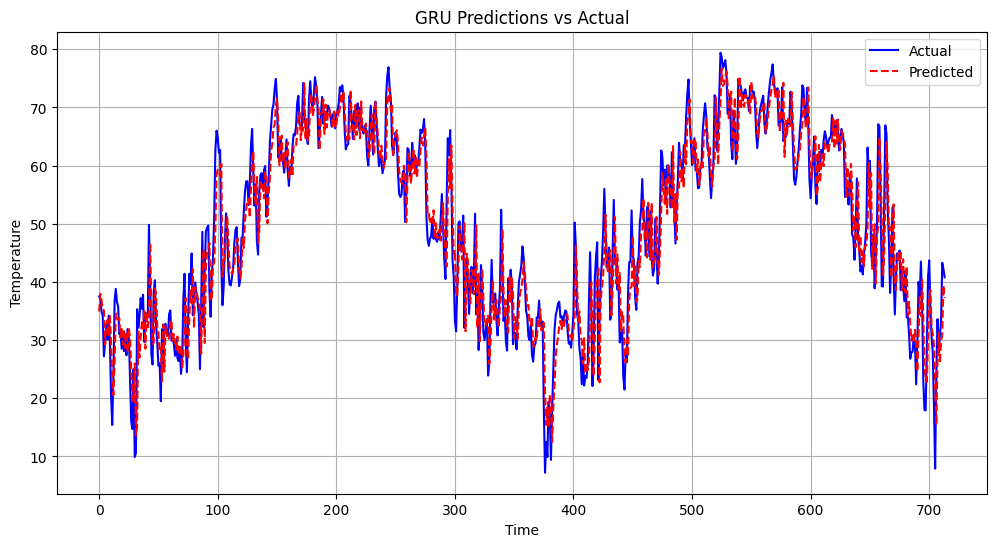

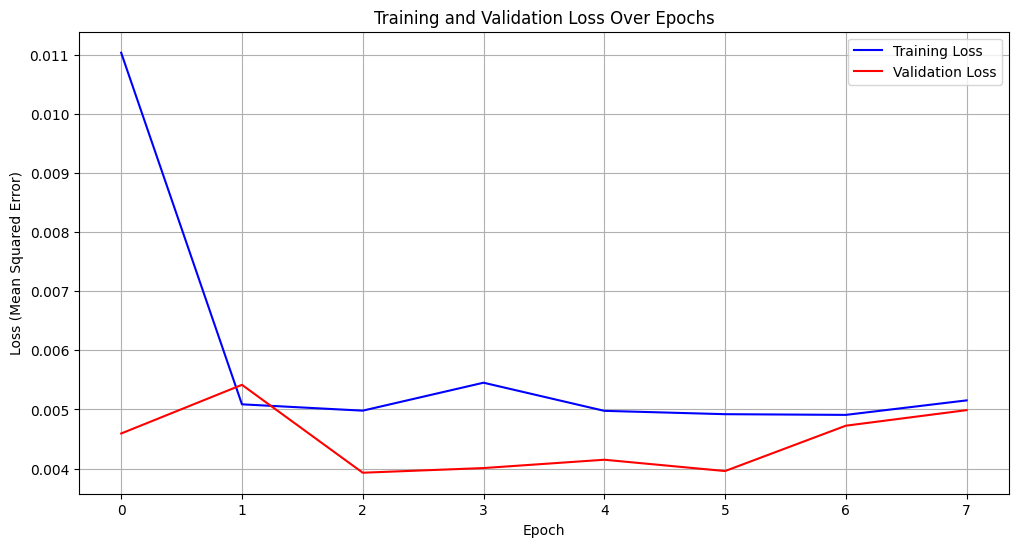


=== 30 Days Future Forecast (Numeric) ===
      Date  Forecasted_TEMP
2025-01-01        32.565811
2025-01-02        33.607574
2025-01-03        34.199417
2025-01-04        34.441063
2025-01-05        34.507328
2025-01-06        34.488567
2025-01-07        34.437908
2025-01-08        34.381565
2025-01-09        34.329178
2025-01-10        34.282196
2025-01-11        34.239273
2025-01-12        34.198799
2025-01-13        34.159546
2025-01-14        34.120758
2025-01-15        34.082081
2025-01-16        34.043343
2025-01-17        34.004623
2025-01-18        33.966118
2025-01-19        33.927879
2025-01-20        33.889904
2025-01-21        33.852257
2025-01-22        33.814972
2025-01-23        33.777790
2025-01-24        33.740623
2025-01-25        33.703644
2025-01-26        33.666874
2025-01-27        33.630276
2025-01-28        33.593788
2025-01-29        33.557446
2025-01-30        33.521324


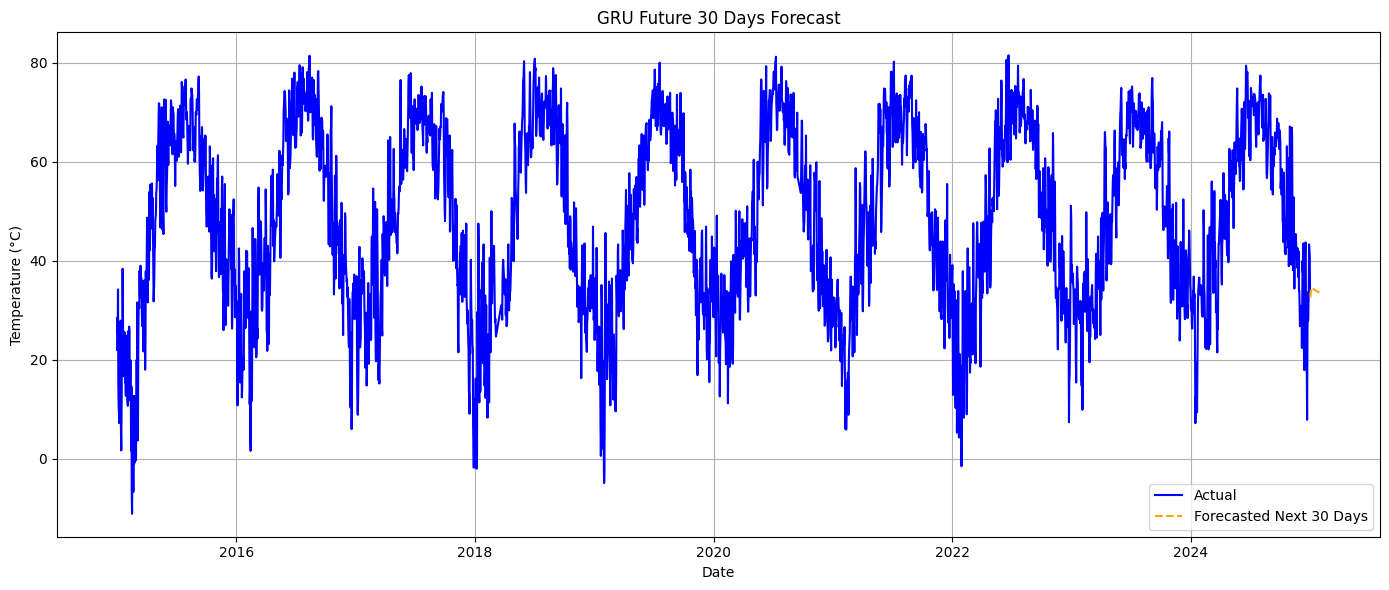

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Data Preparation ===
temp_series = df['TEMP'].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(np.array(temp_series).reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, Y = create_dataset(temp_scaled, look_back)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

# Reshape input for GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# === 2. Hyperparameter Tuning ===
def build_model(hp):
    model = Sequential()
    # 1st GRU layer
    model.add(GRU(
        units=hp.Int('gru_units1', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    # 2nd GRU layer
    model.add(GRU(
        units=hp.Int('gru_units2', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=True
    ))
    # 3rd GRU layer
    model.add(GRU(
        units=hp.Int('gru_units3', min_value=32, max_value=128, step=16),
        activation=hp.Choice('activation', ['relu', 'tanh'])
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='gru_tuner_dir',
    project_name='gru_forecast_tuning'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run hyperparameter tuning
tuner.search(X_train, Y_train, epochs=50, batch_size=5, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

print("\n=== Best Hyperparameters Found ===")
print(f"1st GRU Units: {best_hp.get('gru_units1')}")
print(f"2nd GRU Units: {best_hp.get('gru_units2')}")
print(f"3rd GRU Units: {best_hp.get('gru_units3')}")
print(f"Activation Function: {best_hp.get('activation')}")
print(f"Optimizer: {best_hp.get('optimizer')}")

# Build and train best model
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train, Y_train, epochs=100, batch_size=5, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# === 3. Make Predictions ===
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# === 4. Evaluation ===
train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
train_r2 = r2_score(Y_train[0], train_predict[:,0])  # Added Train R²
test_r2 = r2_score(Y_test[0], test_predict[:,0])

print("\n=== Model Evaluation ===")
print('Train RMSE: %.2f' % (train_rmse))
print('Test RMSE: %.2f' % (test_rmse))
print('Train R² Score: %.2f' % (train_r2))  # Added Train R²
print('Test R² Score: %.2f' % (test_r2))

# === 5. Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(Y_test[0], label='Actual', color='blue')
plt.plot(test_predict[:,0], label='Predicted', color='red', linestyle='--')
plt.title('GRU Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# === 6. Plot Training and Validation Loss ===
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

# === 7. Forecast 30 Future Days ===
future_input = temp_scaled[-look_back:]
future_input = future_input.reshape(1, look_back, 1)

future_predictions = []

for _ in range(30):
    future_pred = model.predict(future_input, verbose=0)
    future_predictions.append(future_pred[0, 0])
    future_input = np.append(future_input[:,1:,:], [[[future_pred[0,0]]]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create forecast DataFrame
future_forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_TEMP': future_predictions.flatten()})

# === 8. Display Future Predictions ===
print("\n=== 30 Days Future Forecast (Numeric) ===")
print(future_forecast_df.to_string(index=False))

# === 9. Plot Future Forecast ===
plt.figure(figsize=(14,6))
plt.plot(df['DATE'], df['TEMP'], label='Actual', color='blue')
plt.plot(future_forecast_df['Date'], future_forecast_df['Forecasted_TEMP'], label='Forecasted Next 30 Days', color='orange', linestyle='--')
plt.title('GRU Future 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (\u00b0C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()